# MSAAI 541 Capston Project: Face Generation with GANs
#### Eduardo Jimenez, Kevin Mai, Ratul Nandy, Cole O'Connell



In [92]:
# import some basic packages
import os
import glob
import time
import datetime
import numpy as np

# import tf packages for constructing and training the networks
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

# import image manipulation and preprocessing libraries 
import PIL
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing

In [69]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
drive_path = '/content/drive/Shareddrives/capstone/faces2/celebb/img_align_celebb/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
## May need to run cell 2x as it may error on first attempt due to Colab bug

# change below line to your filepath
#!unzip '/content/gdrive/shareddrives/capstone/celebb.zip' -d "/content/gdrive/Shareddrives/capstone/faces2"

# set up path for loading images
impath = drive_path + 'img_align_celebb/'

# create array containing the images in drive
raw_images =[]
for filename in os.listdir(impath): 
  im = cv2.imread(impath + filename)
  raw_images.append(im)

# we found 999 and 998 corrupted so we replace them here
raw_images[999]=raw_images[0]
raw_images[998]=raw_images[1]

In [71]:
# load a face classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# function for preprocessing images by auto-cropping to the faces when detected
def preprocess(images):
  # initialize variables for storing the images and counting discarded images
  images =[]
  nff_count = 0
  # convert to grayscale and run face classifier
  for i in range(len(raw_images)):
    im = raw_images[i]
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    # try to identify face as region of interest
    try:
        for (x,y,w,h) in faces:
            roi_color = im[y:y+h, x:x+w]
        # if face found, then resize and recolor
        resized = cv2.resize(roi_color, (32,32))
        recolored = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        images.append(recolored)
    except:
      nff_count += 1
      pass
  return images, nff_count

images, nff_count = preprocess(raw_images)
print("Images where no face was found: ", nff_count)

Images where no face was found:  0


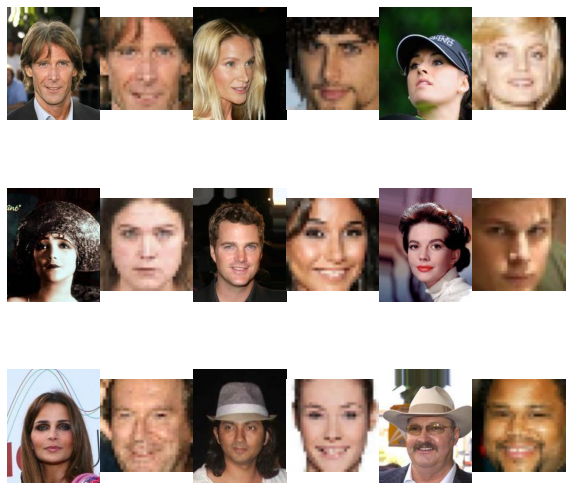

In [72]:
# display comparison between raw images and input images for the model
fig = plt.figure(figsize=(10,20))
for image in range(18):
  if image % 2 == 0:
    plt.subplot(6,6,1+image)
    plt.axis('off')
    plt_im = cv2.cvtColor(raw_images[image], cv2.COLOR_BGR2RGB)
    plt.imshow(plt_im)
  else:
    previous_image = image - 1
    plt.subplot(6,6,1+image)
    plt.axis('off')
    plt_im = images[image]
    plt.imshow(plt_im)
    
fig.subplots_adjust(wspace=0.0, hspace=0.0)
plt.show()

## Neural Networks

In [73]:
# Training hyperparams
epochs = 100
batch = 32
buffer = 10000
seed_vec_len = 100

# Model Optimizers
gen_optimizer = tf.keras.optimizers.Adam(2.0e-4,0.5)
disc_optimizer = tf.keras.optimizers.Adam(1.0e-4,0.5)
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [74]:
# define resolution and number of color channels
im_pixels = 32 
color_channels = 3

# prep the input data for input into network
def train_prep(input):
  train = np.asarray(input)
  train = np.reshape(train,(-1,im_pixels,im_pixels,color_channels))
  train = train.astype(np.float32)
  print(train.shape)
  train = train / 127.5 - 1.
  train = tf.data.Dataset.from_tensor_slices(train) \
    .shuffle(buffer).batch(batch)
  return train

train_data = train_prep(images)

(19608, 32, 32, 3)


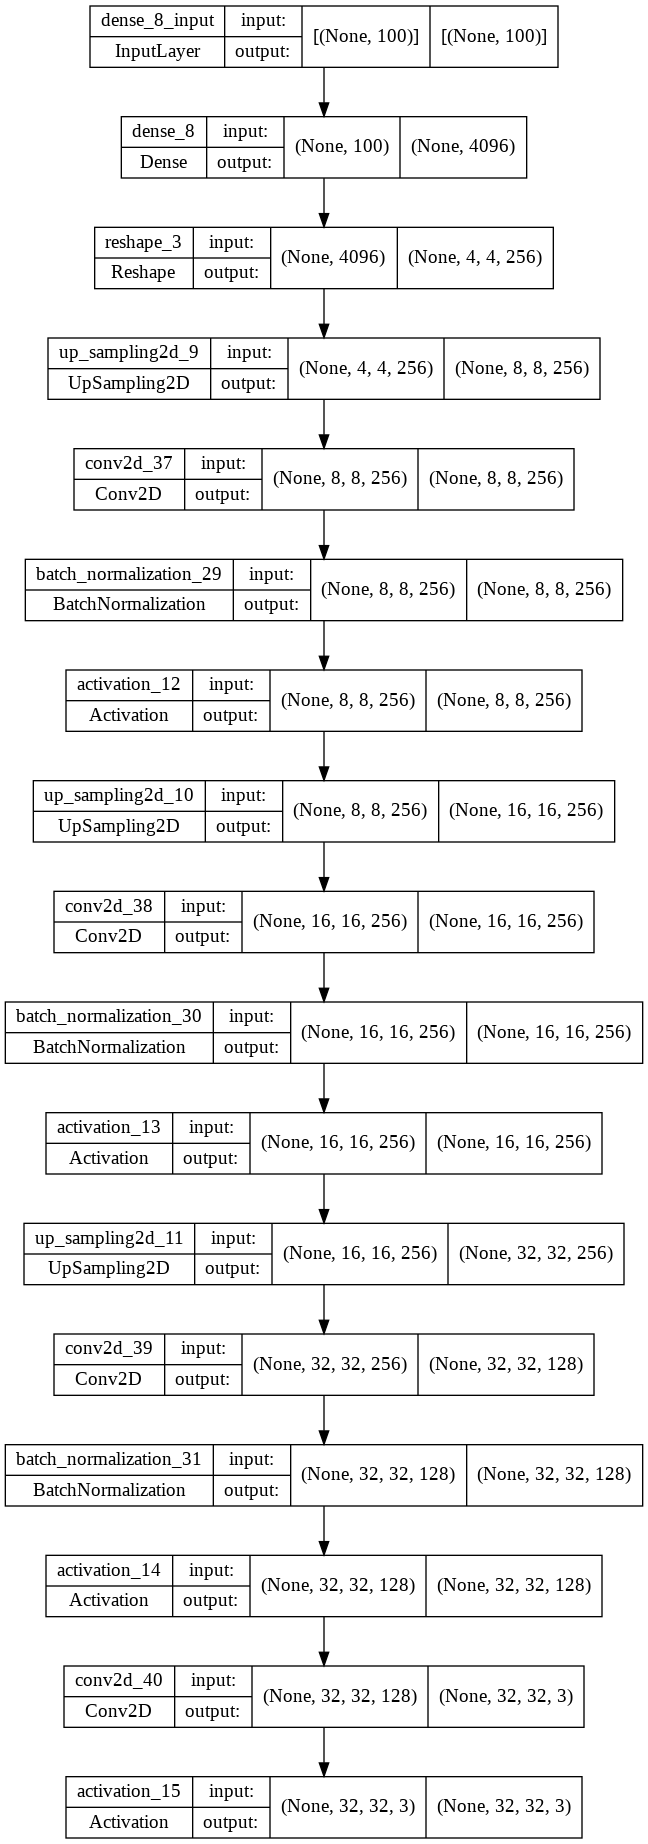

In [96]:
def build_generator(seed_vec_len, channels):
    model = Sequential()
    model.add(Dense(4*4*256,activation="relu",input_dim=seed_vec_len))
    model.add(Reshape((4,4,256)))
    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))
    return model

def generator_loss(gen_output):
    return cross_entropy(tf.ones_like(gen_output), gen_output)

# build generator model
generator = build_generator(seed_vec_len, color_channels)

plot_model(generator, to_file='gen_plot.png', show_shapes=True, show_layer_names=True)

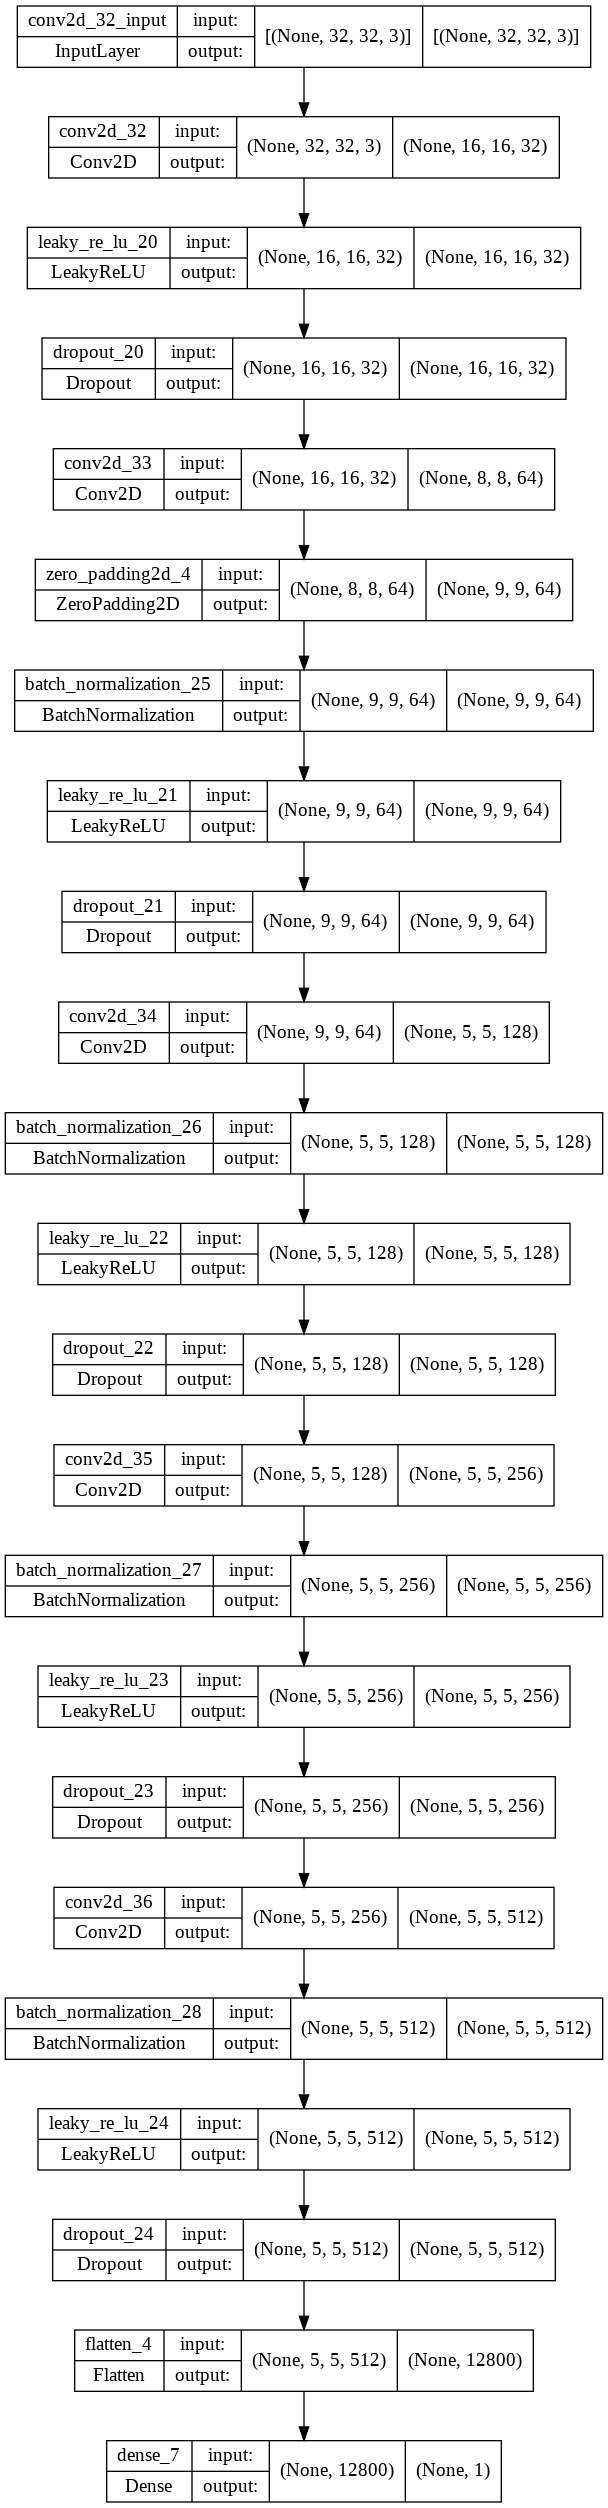

In [95]:
def build_discriminator(image_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

def discriminator_loss(real_output, gen_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(gen_output), gen_output)
    total_loss = real_loss + fake_loss
    return total_loss

# build discriminator model
discriminator = build_discriminator((im_pixels, im_pixels, color_channels))

plot_model(discriminator, to_file='disc_plot.png', show_shapes=True, show_layer_names=True)

In [77]:
# compile the models
@tf.function

# simple timestamp function
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# define function for single training step
def train_step(images):
  seed = tf.random.normal([batch, seed_vec_len])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)
    real_output = discriminator(images, training=True)
    gen_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(gen_output)
    disc_loss = discriminator_loss(real_output, gen_output)
    gen_gradient = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)
    gen_optimizer.apply_gradients(zip(
        gen_gradient, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(
        disc_gradient, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

# define full training function
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (rows * cols, seed_vec_len))
  start = time.time()
  for epoch in range(epochs):
    epoch_start = time.time()
    gen_loss_list = []
    disc_loss_list = []
    for im_batch in dataset:
      t = train_step(im_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])
    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)
    epoch_time = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           f' {hms_string(epoch_time)}')
    save_images(epoch,fixed_seed)
  total_time = time.time()-start
  print (f'Training time: {hms_string(total_time)}')

In [78]:
# params for saved image grid
rows = 4
cols = 7
margin = 16

# function to save images
def save_images(epoch,input):
  im_count = 0
  image_array = np.full(( 
    margin + (rows * (im_pixels+margin)), 
    margin + (cols * (im_pixels+margin)), color_channels), 
    255, dtype=np.uint8)
  output_path = os.path.join(drive_path,'GAN_OUTPUT')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  generator_ims = generator.predict(input)
  generator_ims = 0.5 * generator_ims + 0.5
  for row in range(rows):
      for col in range(cols):
        r = row * (im_pixels+16) + margin
        c = col * (im_pixels+16) + margin
        image_array[r:r+im_pixels,c:c+im_pixels] \
            = generator_ims[im_count] * 255
        im_count += 1
  im = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
  im = PIL.Image.fromarray(im)
  im.save(os.path.join(output_path,f"train-{epoch}-{ts}.png"))

In [79]:
ts = datetime.datetime.now().timestamp()
#train(train_data, epochs)
#generator.save(os.path.join(drive_path,f"face_generator_{ts}.h5"))

## Latent Space Interpolation

In [80]:
# load latest model 
model_name = "face_generator_1660354036.112521.h5"
model_h = load_model(os.path.join(drive_path,model_name))
model_h.compile()

In [81]:
def generate_latent_points(latent_dims, num_points):
  # generate points in the latent space
  noise = np.random.randn(num_points * latent_dims)
  # reshape for generator
  vector = noise.reshape(num_points, latent_dims)
  return vector

def interpolate_points(start_point, end_point, n_steps):
  vectors = []
  # gets evenly spaced points between 0 and 1
  intermediate_points = np.linspace(0, 1, num=n_steps)
  # interpolate for each space
  for i in intermediate_points:
    vec = (1.0 - i) * start_point + i * end_point
    vectors.append(vec)
  points = np.asarray(vectors)
  return points

In [82]:
points = generate_latent_points(100, 2)
interpolated = interpolate_points(points[0], points[1], 10)
generated_faces = model_h.predict(interpolated)

generated_faces = (generated_faces + 1) / 2.0

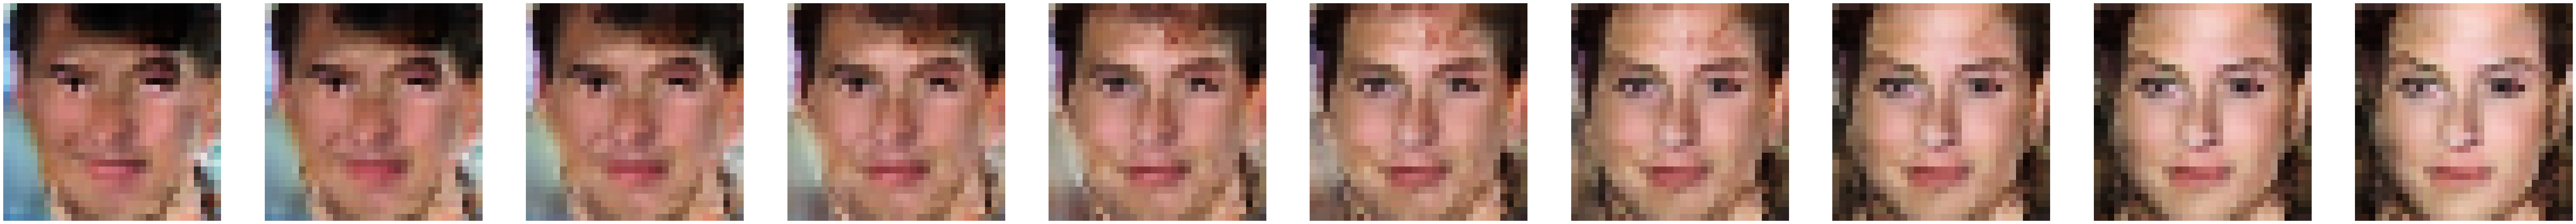

In [83]:
def plot_interpolation(examples, n):
  fig = plt.figure(figsize=(100,50))
 	# plot images
  for i in range(n):
    plt.subplot(1, n, 1 + i)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(examples[i, :, :], cv2.COLOR_BGR2RGB))
plot_interpolation(generated_faces, len(interpolated))

## Vector Arithmetic

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


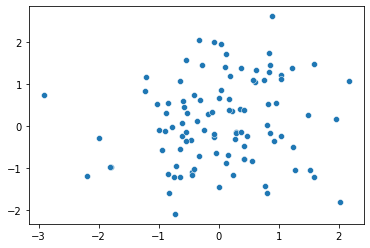

In [84]:
# Generate 100 points
latent_points = generate_latent_points(100, 100)
sns.scatterplot(latent_points[0], latent_points[99])
generated_faces  = model_h.predict(latent_points)
generated_faces = (generated_faces + 1) / 2.0

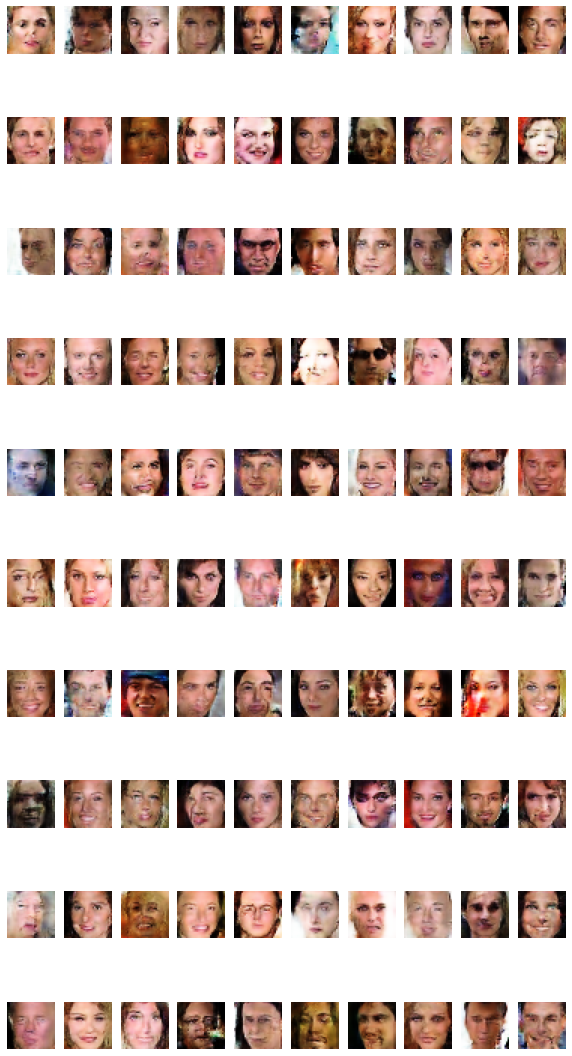

In [85]:
fig = plt.figure(figsize=(10,20))
for image in range(100):
  plt.subplot(10,10,1+image)
  plt.axis('off')
  plt.imshow(cv2.cvtColor(generated_faces[image], cv2.COLOR_BGR2RGB))
plt.show()

In [97]:
# MUST MANUALLY ENTER NUMBER FOR CORRESPONDING FACES
female = [50,51,2,7,20,21]
female_smile = [90,91,80,82,71,72,77,69] 
male = [0,1,10,90,98,99]
male_smile = [9,31,32,49,52]

# average the vectors with desired feature
def average_points(points, idx): 
  #zero_ix = [i-1 for i in ix]
  vectors = points[idx]
  avg_vector = np.mean(vectors, axis=0)
  return avg_vector

# calculate vector representations for each feature
feat_female = average_points(latent_points, female)
feat_female_smile = average_points(latent_points, female_smile)
feat_male = average_points(latent_points, male)
feat_male_smile = average_points(latent_points, male_smile)

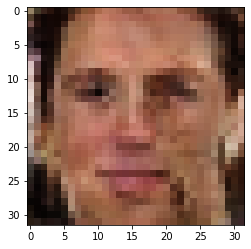

In [98]:
male_vector = np.expand_dims(feat_male, 0)
male_face = model_h.predict(male_vector)
male_face_im = (male_face + 1) / 2.0
plt.imshow(cv2.cvtColor(male_face_im[0], cv2.COLOR_BGR2RGB))
plt.show()

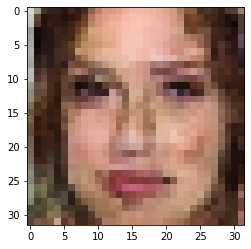

In [99]:
female_vector = np.expand_dims(feat_female, 0)
female_face = model_h.predict(female_vector)
female_face_im = (female_face + 1) / 2.0
plt.imshow(cv2.cvtColor(female_face_im[0], cv2.COLOR_BGR2RGB))
plt.show()

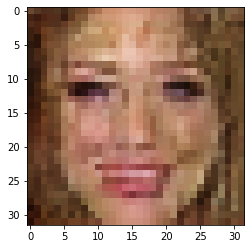

In [100]:
female_smile_vector = np.expand_dims(feat_female_smile, 0)
female_smile = model_h.predict(female_smile_vector)
female_smile_im = (female_smile + 1) / 2.0
plt.imshow(cv2.cvtColor(female_smile_im[0], cv2.COLOR_BGR2RGB))
plt.show()

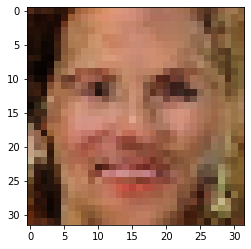

In [101]:
smiling_man = feat_male + feat_female_smile - feat_female
smiling_man = np.expand_dims(smiling_man, 0)
smiling_man_face = model_h.predict(smiling_man)
smiling_man_im = (smiling_man_face + 1) / 2.0
plt.imshow(cv2.cvtColor(smiling_man_im[0], cv2.COLOR_BGR2RGB))
plt.show()